# Scientific Python
## Central European University // Fall 2021

## Final Project
Instructor: Marton Posfai

Student: Alessandra Oshiro


## 1. Introduction

## 2. Loading and cleaning the dataset



In [318]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [319]:
social_movements_df = pd.read_csv("social_movements.csv")
social_movements_df.head(5)

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes
0,201990001,Canada,20,1990,North America,1,1,15.0,1.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. great canadian train journeys into history;...,canada s railway passenger system was finally ...
1,201990002,Canada,20,1990,North America,1,2,25.0,6.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. autonomy s cry revived in quebec the new yo...,protestors were only identified as young peopl...
2,201990003,Canada,20,1990,North America,1,3,1.0,7.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. quebec protest after queen calls for unity ...,"the queen, after calling on canadians to remai..."
3,201990004,Canada,20,1990,North America,1,4,12.0,7.0,1990.0,...,NaN,accomodation,NaN,NaN,NaN,NaN,NaN,NaN,1. indians gather as siege intensifies; armed ...,canada s federal government has agreed to acqu...
4,201990005,Canada,20,1990,North America,1,5,14.0,8.0,1990.0,...,NaN,crowd dispersal,arrests,accomodation,NaN,NaN,NaN,NaN,1. dozens hurt in mohawk blockade protest the ...,protests were directed against the state due t...


In [320]:
social_movements_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17145 entries, 0 to 17144
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     17145 non-null  int64  
 1   country                17145 non-null  object 
 2   ccode                  17145 non-null  int64  
 3   year                   17145 non-null  int64  
 4   region                 17145 non-null  object 
 5   protest                17145 non-null  int64  
 6   protestnumber          17145 non-null  int64  
 7   startday               15239 non-null  float64
 8   startmonth             15239 non-null  float64
 9   startyear              15239 non-null  float64
 10  endday                 15239 non-null  float64
 11  endmonth               15239 non-null  float64
 12  endyear                15239 non-null  float64
 13  protesterviolence      15758 non-null  float64
 14  location               15218 non-null  object 
 15  pa

This initial summary shows that there are some NaN values in our datset. Moreover, by the name and description of the variables, it is possible to tell that some of the data will not be relevant for the analysis. Therefore, it is now turn to clean the data and drop the columns that will not be needed. First, I will drop the columns that do not provide relevant information, then I will drop those who have a high proportion of NaNs. 

In [321]:
social_movements_df.drop(["id", "ccode", "protesteridentity", "participants_category", "location", "sources", "notes"], axis = 1, inplace = True)

In [322]:
column_na_proportion = social_movements_df.isna().sum()/len(social_movements_df)
print(column_na_proportion)

country              0.000000
year                 0.000000
region               0.000000
protest              0.000000
protestnumber        0.000000
startday             0.111169
startmonth           0.111169
startyear            0.111169
endday               0.111169
endmonth             0.111169
endyear              0.111169
protesterviolence    0.080898
participants         0.081598
protesterdemand1     0.111228
protesterdemand2     0.826363
protesterdemand3     0.977661
protesterdemand4     0.951531
stateresponse1       0.112978
stateresponse2       0.831554
stateresponse3       0.945757
stateresponse4       0.985768
stateresponse5       0.950481
stateresponse6       0.999067
stateresponse7       0.946340
dtype: float64


In [323]:
social_movements_df.dropna(subset = ["stateresponse1", "protesterdemand1"], inplace = True)

In [324]:
column_na_proportion = social_movements_df.isna().sum()/len(social_movements_df)
print(column_na_proportion)

country              0.000000
year                 0.000000
region               0.000000
protest              0.000000
protestnumber        0.000000
startday             0.000000
startmonth           0.000000
startyear            0.000000
endday               0.000000
endmonth             0.000000
endyear              0.000000
protesterviolence    0.000000
participants         0.000789
protesterdemand1     0.000000
protesterdemand2     0.804971
protesterdemand3     0.974882
protesterdemand4     0.948777
stateresponse1       0.000000
stateresponse2       0.810231
stateresponse3       0.938848
stateresponse4       0.983956
stateresponse5       0.947593
stateresponse6       0.998948
stateresponse7       0.943648
dtype: float64


In the previous cell, I have calculated the proportion of NaNs per column. As we can see, there are several columns that have a proportion of NaNs of almost 1. The cases in which this is more evident, is the variables for protesters demands and those for state response. This is because, for some mobilizations, protesters have had different demands and states have answered in different ways as the conflict progressed. Given that eliminating straight away those variables would not give us accurate information about the state response, I have decided to recode "stateresponse1" to "stateresponse7" as a single variable that indicates whether the response was pacific (accomodation or agreement) or used force (arrests, dispersion, shootings, killings).

In [325]:
social_movements_df = social_movements_df[social_movements_df["stateresponse2"].isna()]
social_movements_df = social_movements_df[social_movements_df["protesterdemand2"].isna()]

In [326]:
social_movements_df.drop(
    ["protesterdemand2", "protesterdemand3", "protesterdemand4", 
    "stateresponse2", "stateresponse3", "stateresponse4", 
    "stateresponse5", "stateresponse6", "stateresponse7"], axis = 1, inplace=True)

social_movements_df = social_movements_df.dropna()

Now, I recode some variables so that they are adequate for the binary classification. First, the variable for protester demands ("protesterdemand1") is coded "economical" for economical demands (labor wage dispute, land farm issue, and price increases/tax policy) and "political" for political demands (police brutality, removal of politician, political behavior or processes, and social restrictions). This information is stored as the "demand_type" variable in the dataframe. 

The same procedure was done with the variable for state response ("stateresponse1"). In this case, the new variable indicates whether the state made use of force in its response to the mass mobilization. Therefore, it is coded 0 for pacific responses (ignore, or accomodation) and 1 for forceful responses (dispersion, arrest, shooting, and killing). This data is stired as the "response_use_force" variable in the dataframe.

In [327]:
demands_mask = social_movements_df["protesterdemand1"].isin(["labor wage dispute", "land farm issue", "price increases, tax policy"])
social_movements_df["demand_type"] = np.where(demands_mask, "economical", "political")

response_mask = social_movements_df["stateresponse1"].isin(["ignore", "accomodation"])
social_movements_df["response_use_force"] = np.where(response_mask, 0, 1)

social_movements_df.head()

,country,year,region,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,participants,protesterdemand1,stateresponse1,demand_type,response_use_force
1,Canada,1990,North America,1,2,25.0,6.0,1990.0,25.0,6.0,1990.0,0.0,1000,"political behavior, process",ignore,political,0
2,Canada,1990,North America,1,3,1.0,7.0,1990.0,1.0,7.0,1990.0,0.0,500,"political behavior, process",ignore,political,0
3,Canada,1990,North America,1,4,12.0,7.0,1990.0,6.0,9.0,1990.0,1.0,100s,land farm issue,accomodation,economical,0
6,Canada,1991,North America,1,1,10.0,9.0,1991.0,17.0,9.0,1991.0,0.0,110000,labor wage dispute,ignore,economical,0
7,Canada,1991,North America,1,2,28.0,9.0,1991.0,2.0,10.0,1991.0,0.0,110000,labor wage dispute,ignore,economical,0


Now, the dates. I have converted them to a single datetime object so that it is easier to calculate other useful data such as the duration of each mobilization. I stared with the start dates and continued with the end dates. After that, I calculated the duration and added it as a new variable in the dataset. 

In [328]:
social_movements_startdate = social_movements_df[["startday", "startmonth", "startyear"]].astype(int).copy()
social_movements_startdate.columns = ["day", "month", "year"]
social_movements_df["start_date"] = pd.to_datetime(social_movements_startdate)

social_movements_enddate = social_movements_df[["endday", "endmonth", "endyear"]].astype(int).copy()
social_movements_enddate.columns = ["day", "month", "year"]
social_movements_df["end_date"] = pd.to_datetime(social_movements_enddate)

social_movements_df.head()


,country,year,region,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,participants,protesterdemand1,stateresponse1,demand_type,response_use_force,start_date,end_date
1,Canada,1990,North America,1,2,25.0,6.0,1990.0,25.0,6.0,1990.0,0.0,1000,"political behavior, process",ignore,political,0,1990-06-25,1990-06-25
2,Canada,1990,North America,1,3,1.0,7.0,1990.0,1.0,7.0,1990.0,0.0,500,"political behavior, process",ignore,political,0,1990-07-01,1990-07-01
3,Canada,1990,North America,1,4,12.0,7.0,1990.0,6.0,9.0,1990.0,1.0,100s,land farm issue,accomodation,economical,0,1990-07-12,1990-09-06
6,Canada,1991,North America,1,1,10.0,9.0,1991.0,17.0,9.0,1991.0,0.0,110000,labor wage dispute,ignore,economical,0,1991-09-10,1991-09-17
7,Canada,1991,North America,1,2,28.0,9.0,1991.0,2.0,10.0,1991.0,0.0,110000,labor wage dispute,ignore,economical,0,1991-09-28,1991-10-02


In [329]:
social_movements_df = social_movements_df.reset_index(drop=True)
movement_duration = [(social_movements_df["end_date"][i] - social_movements_df["start_date"][i]).days for i in range(len(social_movements_df))]
social_movements_df["movement_duration"] = movement_duration



In [330]:
social_movements_df = social_movements_df[["country", "year", "region", "start_date", "end_date", "movement_duration","protest", "protestnumber", "protesterviolence", "participants", "protesterdemand1", "demand_type", "stateresponse1", "response_use_force"]]
social_movements_df.columns = ["country", "year", "region", "start_date", "end_date", "movement_duration", "protest", "protest_number", "protester_violence", "participants", "protester_demand", "demand_type", "state_response", "response_use_force"]

In [331]:
social_movements_df.head(20)

,country,year,region,start_date,end_date,movement_duration,protest,protest_number,protester_violence,participants,protester_demand,demand_type,state_response,response_use_force
0,Canada,1990,North America,1990-06-25,1990-06-25,0,1,2,0.0,1000,"political behavior, process",political,ignore,0
1,Canada,1990,North America,1990-07-01,1990-07-01,0,1,3,0.0,500,"political behavior, process",political,ignore,0
2,Canada,1990,North America,1990-07-12,1990-09-06,56,1,4,1.0,100s,land farm issue,economical,accomodation,0
3,Canada,1991,North America,1991-09-10,1991-09-17,7,1,1,0.0,110000,labor wage dispute,economical,ignore,0
4,Canada,1991,North America,1991-09-28,1991-10-02,4,1,2,0.0,110000,labor wage dispute,economical,ignore,0
5,Canada,1992,North America,1992-05-04,1992-05-05,1,1,1,1.0,1000,police brutality,political,arrests,1
6,Canada,1993,North America,1993-05-16,1993-05-16,0,1,1,0.0,10000s,"political behavior, process",political,ignore,0
7,Canada,1993,North America,1993-07-01,1993-08-31,61,1,2,0.0,100s,"political behavior, process",political,arrests,1
8,Canada,1994,North America,1994-09-01,1994-09-01,0,1,1,0.0,10000,"political behavior, process",political,ignore,0
9,Canada,1994,North America,1994-11-18,1994-11-18,0,1,2,0.0,6000,"price increases, tax policy",economical,ignore,0


## Exploring the dataset

This section is dedicated to the first objective of the project, that is, to explore the trends in mass mobilizations. Here, I intend to do some descriptive statistics to be able to identify the variables that could be good predictors for elaborating a machine learning model in the next section. 

In [332]:
massmob_per_year_northamerica = social_movements_df[social_movements_df["region"] == "North America"].groupby("year").size()
massmob_per_year_centralamerica = social_movements_df[social_movements_df["region"] == "Central America"].groupby("year").size()
massmob_per_year_southamerica = social_movements_df[social_movements_df["region"] == "South America"].groupby("year").size()
massmob_per_year_europe = social_movements_df[social_movements_df["region"] == "Europe"].groupby("year").size()
massmob_per_year_asia = social_movements_df[social_movements_df["region"] == "Asia"].groupby("year").size()
massmob_per_year_mena = social_movements_df[social_movements_df["region"] == "MENA"].groupby("year").size()
massmob_per_year_africa = social_movements_df[social_movements_df["region"] == "Africa"].groupby("year").size()

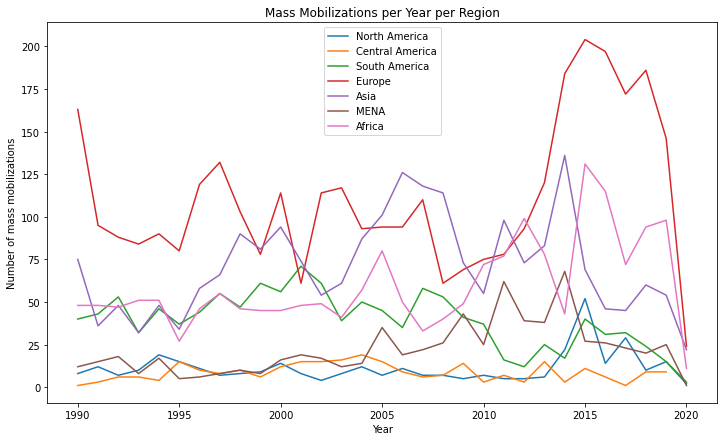

In [354]:
plt.figure(figsize = (12,7))

plt.plot(massmob_per_year_northamerica.index, massmob_per_year_northamerica, label = "North America")
plt.plot(massmob_per_year_centralamerica.index, massmob_per_year_centralamerica, label = "Central America")
plt.plot(massmob_per_year_southamerica.index, massmob_per_year_southamerica, label = "South America")
plt.plot(massmob_per_year_europe.index, massmob_per_year_europe, label = "Europe")
plt.plot(massmob_per_year_asia.index, massmob_per_year_asia, label = "Asia")
plt.plot(massmob_per_year_mena.index, massmob_per_year_mena, label = "MENA")
plt.plot(massmob_per_year_africa.index, massmob_per_year_africa, label = "Africa")
plt.legend()
plt.title("Mass Mobilizations per Year per Region");
plt.ylabel("Number of mass mobilizations");
plt.xlabel("Year");

<AxesSubplot:xlabel='region', ylabel='count'>

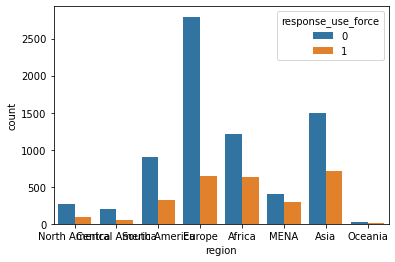

In [348]:
sns.countplot(x = social_movements_df["region"], hue = social_movements_df["response_use_force"])

<AxesSubplot:xlabel='protester_demand', ylabel='count'>

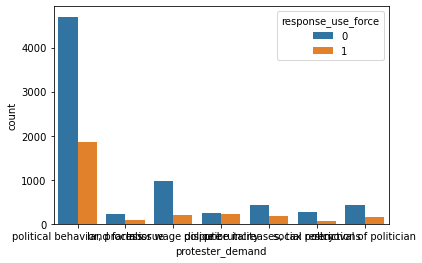

In [347]:
sns.countplot(x = social_movements_df["protester_demand"], hue = social_movements_df["response_use_force"])

In [ ]:
len(social_movements_df)
range(10047)

range(0, 10047)

In [ ]:
social_movements_df.head

<bound method NDFrame.head of                 country  year         region start_date   end_date  \
0                Canada  1990  North America 1990-06-25 1990-06-25   
1                Canada  1990  North America 1990-07-01 1990-07-01   
2                Canada  1990  North America 1990-07-12 1990-09-06   
3                Canada  1991  North America 1991-09-10 1991-09-17   
4                Canada  1991  North America 1991-09-28 1991-10-02   
...                 ...   ...            ...        ...        ...   
10042  Papua New Guinea  2012        Oceania 2012-03-29 2012-03-29   
10043  Papua New Guinea  2012        Oceania 2012-04-10 2012-04-10   
10044  Papua New Guinea  2013        Oceania 2013-08-02 2013-08-02   
10045  Papua New Guinea  2017        Oceania 2017-07-15 2017-07-15   
10046  Papua New Guinea  2017        Oceania 2017-10-31 2017-10-31   

       movement_duration  protest  protest_number  protester_violence  \
0                      0        1               2       

In [ ]:
column_na_proportion = social_movements_df.isna().sum()/len(social_movements_df)
print(column_na_proportion)

country               0.0
year                  0.0
region                0.0
start_date            0.0
end_date              0.0
movement_duration     0.0
protest               0.0
protest_number        0.0
protester_violence    0.0
participants          0.0
protester_demand      0.0
demand_type           0.0
state_response        0.0
response_use_force    0.0
dtype: float64


For the case of protesters demands, I did something similar. Here, I have recoded "protesterdemand1" to "protesterdemand4" as a single variable that indicates the nature of the demand. There are three categories: economical, political, both. 

Then, I formatted the variables for the starting and finishing dates, so that fit in one column each instead of three separate ones. For this, I used the datetime module, given that this allows me to calculate the duration of each mobilization. The duration has also been added to the dataframe because it could be a relevant predictor for the machine learning model. 

In [ ]:
start_time_complete = list(
    zip(social_movements_df["startday"], 
            social_movements_df["startmonth"], 
            social_movements_df["startyear"]))

start_time_complete

KeyError: 'startday'

In [ ]:
end_time_complete = list(
    zip(social_movements_df["endday"], 
            social_movements_df["endmonth"], 
            social_movements_df["endyear"]))

for row in end_time_complete: 
    

SyntaxError: unexpected EOF while parsing (<ipython-input-191-6cb0467dcf0d>, line 7)

Finally, to conclude the data cleaning process, I dropped the observations which had NaNs. 

In [ ]:
col_names = column_na_proportion.index
valid_cols = [col for col in col_names if column_na_proportion[col] < 0.5]
social_movements_df = social_movements_df[valid_cols]
social_movements_df.head()